<h1><center>SimpleITK Tutorial</center></h1>

# Deformable Transformations with SimpleITK

Author: José D. Tascón-Vidarte \
Email: jota@di.ku.dk \
University of Copenhagen

Objectives:
- Learn how to apply transformations to images with SimpleITK

The documentation of SimpleITK is available at https://itk.org/SimpleITKDoxygen100/html/index.html

This tutorial is based on the Notebooks provided by the Insight Software Consortium. http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/

##  Cloning files

Open the files to be used from github.

In [1]:
# !rm -rf /content/registration_tutorial/
# !git clone https://github.com/josetascon/registration_tutorial.git

## Import libraries
Import the libraries to be used.

In [2]:
# !pip install simpleitk           # install simpleitk in colabs

import SimpleITK as sitk         # simpleitk library
import sys                       # sys library, used to include local py files
import numpy as np               # array and matrix library
import matplotlib.pyplot as plt  # plot library

from ipywidgets import interact, fixed # jupyter widgets libraries

# sys.path.insert(0, '/content/registration_tutorial/') # local library path
from local_utils import image_info, imshow_2d # local file local_utils.py

Examples here in 2D to simplify

## Selection of an Image

All the transformations presented here can be applied to a set of images defined here. These images show how the transformation affect the region of interest. The images are:

* grid.png: image with a grid pattern in black and white.
* sinc.png: image with a 2D sinc function
* geometric.png: image with geometric primitives such as rentangles, triangles and circles.
* 'file'_pad.png: image with extra pixels around the borders to observe trasnformations.  

In [3]:
def image_select(list_images):
    # Function to be called with interact to select one image from the list_images
    # Input: list_images (list of strings with file names)
    # Output: None
    global img # variable to store the image to be used for all operations in this notebook
    prefix = 'images/'
    img = sitk.ReadImage(prefix + list_images, sitk.sitkFloat64)
    print(image_info(img))
    imshow_2d(img)
    return

In [4]:
dimension = 2

global img # variable to store the image to be used for all operations in this notebook

list_images = ['grid.png', 'grid_pad.png', 'sinc.png',
            'sinc_pad.png', 'geometric.png', 'geometric_pad.png']

interact(image_select, list_images = list_images);

# Colabs code
# selection = 0
# prefix = '/content/registration_tutorial/images/' # colabs path
# img = sitk.ReadImage(prefix + list_images[selection], sitk.sitkFloat64)
# print(image_info(img))
# imshow_2d(img)

interactive(children=(Dropdown(description='list_images', options=('grid.png', 'grid_pad.png', 'sinc.png', 'si…

## Utils Functions to Transform Images

Similar to the utility functions for images, here a set of functions to use transformations is defined.

In [5]:
def get_name_transform( str_transform ):
    # Return class name of transformation using its string object
    # Input: string (transform.ToString())
    # Output: string
    name = str_transform.split()
    return name[1] # transform class name always in second line

def transform_info( transform ):
    # Return a string with information about the transformation.
    # Input: sitk.Transform
    # Output: string
    info = '\n===== Transform Info ====='
    info += '\nTransform type: \t' + get_name_transform(str(transform))
    info += '\nDimensions: \t\t' + str(transform.GetDimension())
    info += '\nParameters: \t\t' + str(transform.GetParameters())
    info += '\n'
    return info

def transform_point(point, transform, verbose = True):
    # Apply a transformation to a point
    # Inputs: tuple, sitk.Transform, bool 
    # Output: tuple
    transformed_point = transform.TransformPoint(point)
    if verbose:
        info = '\n===== Transform Point ====='
        info += '\nPoint: \t\t' + str(point)
        info += '\nTransformed: \t' + str(transformed_point)
        info += '\n'
        print(info)
    return transformed_point

def transform_image(image, transform, interpolator = sitk.sitkLinear, default_value = 0.0):
    # Apply a transform to an image
    # Inputs: sitk.Image, sitk.Transform, sitk.InterpolatorEnum, double
    # Output: sitk.Image
    reference_image = image
    interpolator = interpolator
    return sitk.Resample(image, reference_image, transform, interpolator, default_value)

These functions can be used to apply transformation with SimpleITK.

<b>Note:</b> These functions are stored in a local file called [local_utils.py](./local_utils.py) for further usage.

## Deformable Transformations


SimpleITK supports two deformable transformation models. These are:
* B-spline transformation
* Displacement field


## Bspline Transformation.

This description is taken form [ITK Documentation BSplineTransform](https://itk.org/Doxygen413/html/classitk_1_1BSplineTransform.html)

This class encapsulates a deformable transform of points from one N-dimensional space to another N-dimensional space. The deformation field is modelled using B-splines. A deformation is defined on a sparse regular grid of control points $ \vec{\lambda}_j $ and is varied by defining a deformation $ \vec{g}(\vec{\lambda}_j) $ of each control point. The deformation $ D(\vec{x}) $ at any point $ \vec{x} $ is obtained by using a B-spline interpolation kernel.

The deformation field grid is defined by a user specified transform domain (origin, physical dimensions, direction) and B-spline mesh size where the mesh size is the number of polynomial patches comprising the finite domain of support. The relationship between the mesh size ( number of polynomical pieces) and the number of control points in any given dimension is

mesh size = number of control points - spline order

Each grid/control point has associated with it N deformation coefficients $ \vec{\delta}_j $, representing the N directional components of the deformation. Deformation outside the grid plus support region for the BSpline interpolation is assumed to be zero.

The parameters for this transform is N x N-D grid of spline coefficients. The user specifies the parameters as one flat array: each N-D grid is represented by an array in the same way an N-D image is represented in the buffer; the N arrays are then concatentated together on form a single array.

Here, we create a b-spline transform.

In [6]:
# Define bspline transform
dimension = 2
spline_order = 3
bspline = sitk.BSplineTransform(dimension, spline_order)

# Information about the number of parameter
param = bspline.GetParameters()
num_param = len(param)
print('B-spline of order ' + str(spline_order) + ' with ' + str(num_param) + ' parameters.')

# Information about the transformation
print(transform_info(bspline))

B-spline of order 3 with 32 parameters.

===== Transform Info =====
Transform type: 	BSplineTransform
Dimensions: 		2
Parameters: 		(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)



In the following example a B-spline transform is defined for the entire image. Random values are used to scale the degree of deformation.

In [7]:
# B-spline parameter definition
w = img.GetWidth()
h = img.GetHeight()
origin = [0,0]  # origin of coordinates of region where bspline is applied
direction_matrix_row_major = [1.0,0.0,0.0,1.0] # identity, mesh is axis aligned
domain_physical_dimensions = [w,h]             # dimensions where the bspline is applied
scale = 10

# Set the parameters
bspline.SetTransformDomainOrigin(origin)
bspline.SetTransformDomainDirection(direction_matrix_row_major)
bspline.SetTransformDomainPhysicalDimensions(domain_physical_dimensions)
bspline.SetTransformDomainMeshSize((20,20))

# Random displacement of the control points.
originalControlPointDisplacements = np.random.random(len(bspline.GetParameters()))
bspline.SetParameters(scale*originalControlPointDisplacements)

# Information about the number of parameter
param = bspline.GetParameters()
num_param = len(param)
print('B-spline of order ' + str(spline_order) + ' with ' + str(num_param) + ' parameters.')

# Information about the transformation
print(transform_info(bspline))

B-spline of order 3 with 1058 parameters.

===== Transform Info =====
Transform type: 	BSplineTransform
Dimensions: 		2
Parameters: 		(0.17092300238787606, 4.36818742040985, 4.92653938433993, 4.907466883458852, 9.955079488671682, 7.496433995234377, 7.147616855680745, 8.014871577588737, 7.531571080588263, 6.026371358588292, 8.124981562908127, 7.144419702942351, 4.068848947888402, 3.8330476058575913, 3.526037149260952, 5.4474451038662695, 4.962394905323631, 9.542383066547467, 6.199164673168993, 1.0765956793533693, 3.8451869780755263, 5.481563956031533, 4.750873305866627, 4.101972973956267, 6.053691903635837, 0.393328945307877, 6.067039986165438, 4.713019733249179, 7.7417752531479165, 5.556796075155104, 5.296470444154116, 0.23830344170145734, 4.76129590065483, 8.030280033332078, 3.286862019128942, 3.763830801541065, 6.188277149406197, 3.3349402002966966, 6.302603433507473, 7.329663567033253, 7.086441918691718, 0.5350755126590756, 1.726234685360848, 5.2051647691055205, 4.020886218377705, 7

B-spline transformation of a point

In [8]:
# Translate a point and print the results
point = (8.0, 20.0)
new_point = transform_point(point, bspline)


===== Transform Point =====
Point: 		(8.0, 20.0)
Transformed: 	(11.289746087920978, 22.51148232198438)



B-spline transformation of an image

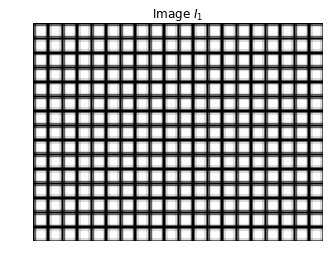

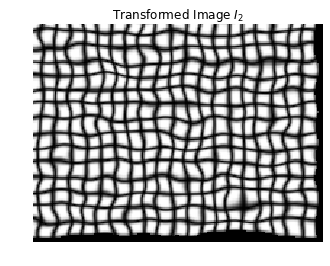

In [9]:
# Apply the transformation to the image
img_t = transform_image(img, bspline)

# Show the results
imshow_2d(img, "Image $I_1$")
imshow_2d(img_t, "Transformed Image $I_2$")

Interacting with B-spline transformation

In [10]:
def imshow_bspline(scale, transform, control_points , image_itk ):
    # Function to bspline transform an image on-line. Intended to be use with interact (Jupyter)
    # Inputs: int, sitk.Transform, bspline_parameters, sitk.Image
    # Output: None
    transform.SetParameters(scale*control_points)
    image_tt = transform_image(image_itk,transform)
    imshow_2d(image_tt, 'Transformed Image')
    

interact(imshow_bspline, scale=(-10,10), transform = fixed(bspline),
         control_points=fixed(originalControlPointDisplacements),image_itk = fixed(img));

interactive(children=(IntSlider(value=0, description='scale', max=10, min=-10), Output()), _dom_classes=('widg…

## Displacement Field

A displacement field transformation is represented as:

$$\phi(x) = x + u(x)$$

In this case a $u(x)$ is a vector defining a displacement for each value $\bf{x}$. 

Remember that in 2D the vector $x$ is the coordinate of a particular pixel.

Here, we create a displacement field transform.

In [11]:
dfield = sitk.DisplacementFieldTransform(dimension)
print(transform_info(dfield))

param = dfield.GetParameters()
num_param = len(param)
print('Displacement field with ' + str(num_param) + ' parameters.')


===== Transform Info =====
Transform type: 	DisplacementFieldTransform
Dimensions: 		2
Parameters: 		()

Displacement field with 0 parameters.


We set the parameters of the displacement field with random values.

In [12]:
size = img.GetSize()

# Defining a displacement field
field_size = [size[0],size[1]]  # full size to cover the entire image
field_origin = [0.0,0.0]  
field_spacing = [1.0,1.0]   
field_direction = [1,0,0,1] # direction cosine matrix (row major order)

# Concatenate all the information into  a single list.
dfield.SetFixedParameters(field_size+field_origin+field_spacing+field_direction)
# dfield.SetParameters(np.ones(len(dfield.GetParameters())))
dfield.SetParameters(1.0*np.random.random_sample(len(dfield.GetParameters())))
# dfield.SetParameters(np.arange(0.0,len(dfield.GetParameters())))

print(transform_info(dfield))

param = dfield.GetParameters()
num_param = len(param)
print('Displacement field with ' + str(num_param) + ' parameters.')


===== Transform Info =====
Transform type: 	DisplacementFieldTransform
Dimensions: 		2
Parameters: 		(0.5613193485878419, 0.4074041618394897, 0.2059424829594, 0.0921041399271374, 0.46243900291573126, 0.597500656905906, 0.578041527695848, 0.3906890431395137, 0.9656187204882057, 0.6354256016604165, 0.5426422668024268, 0.9431465507270594, 0.5449778895812971, 0.2989377979257636, 0.4632350244464728, 0.8870128293796691, 0.4017945905189041, 0.9424369105826559, 0.9627771714557399, 0.5929930869530026, 0.2154286646111565, 0.8056195143473868, 0.429833499986099, 0.7227492814300949, 0.46547826521213453, 0.7266070080007443, 0.35303901008661165, 0.5273718437913565, 0.7510750543047007, 0.09477488707416815, 0.7574897565161832, 0.40815913714636154, 0.3418988619852573, 0.4262677733588244, 0.21898490440887153, 0.757727407152759, 0.9548474929473202, 0.9252400337529623, 0.7784447860629883, 0.6215341842493886, 0.9389472269264101, 0.7530226471686725, 0.26769770807277526, 0.046702944079170305, 0.7043601755538

Displacement field transformation of a point

In [13]:
# Apply the transform to the point
point = (8.0, 20.0)
new_point = transform_point(point, dfield)


===== Transform Point =====
Point: 		(8.0, 20.0)
Transformed: 	(8.862006140820199, 20.26174119588049)



Displacement field transformation of an image

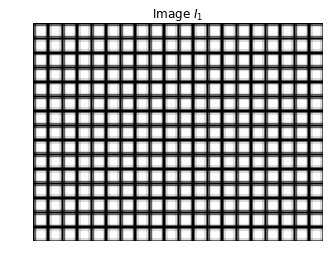

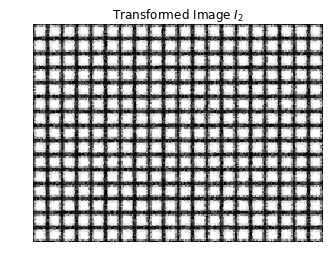

In [14]:
# Apply the deformable transformation
img_df = transform_image(img, dfield)

imshow_2d(img, "Image $I_1$")
imshow_2d(img_df, "Transformed Image $I_2$")

An useful way to obserbe this type of transformation is to draw the corresponding displacement vectors in the image plane. The next function is defined to plot these displacement vectors.

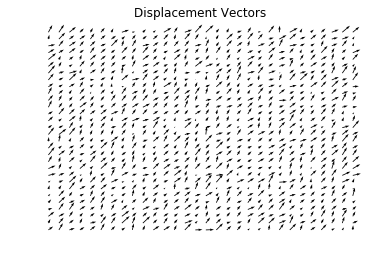

In [15]:
def displacement_vectors(size, transform, samples = 30):
    # Create the coordinates
    numSamplesX = samples
    numSamplesY = samples                 
    coordsX = np.linspace(0, size[0]-1, numSamplesX)
    coordsY = np.linspace(0, size[1]-1, numSamplesY)
    XX, YY = np.meshgrid(coordsX, coordsY)

    # Transform points and compute the vectors.
    vectorsX = np.zeros(XX.shape)
    vectorsY = np.zeros(YY.shape)
    for index, value in np.ndenumerate(XX):
        px,py = transform.TransformPoint((value, YY[index]))
        vectorsX[index] = px - value
        vectorsY[index] = py - YY[index]
        
    return XX, YY, vectorsX, vectorsY

XX, YY, vectorsX, vectorsY = displacement_vectors(img.GetSize(), 
                                                      dfield, samples = 30)

plt.quiver(XX, YY, vectorsX, vectorsY)
plt.title('Displacement Vectors')
plt.axis('off')
plt.show()

### Deformation field using a Function

In this example we create a displacement field transformation based on a function.
The archimedian spiral function is used.

In [16]:
# Define the x and y values
w = img.GetWidth()
h = img.GetHeight()
x, y = np.meshgrid(np.linspace(0,w-1,w), np.linspace(0,h-1,h))

# Creating a spiral function
x1 = x-w/2 # shift to the image center
y1 = y-h/2 # shift to the image center
x2 = -y1*np.arctan(np.sqrt(x1**2 + y1**2))
y2 = x1*np.arctan(np.sqrt(x1**2 + y1**2))
# print(x2[0,0])
# print(y2[0,0])

# Organize the displacement values as a single vector
data = np.array(list(zip(x2.ravel(),y2.ravel())))
data = data.ravel()
print('Displacement values, number of parameters:' + str(data.shape))
# print(data[0:2])

Displacement values, number of parameters:(60000,)


Now, we pass the paramenters to the displacement field

In [17]:
# Defining a displacement field
field_size = [size[0],size[1]]
field_origin = [0.0,0.0]  
field_spacing = [1.0,1.0]   
field_direction = [1,0,0,1] # direction cosine matrix (row major order)

# Concatenate all the information into  a single list.
dfield.SetFixedParameters(field_size+field_origin+field_spacing+field_direction)
dfield.SetParameters(2*data)

print(transform_info(dfield))


===== Transform Info =====
Transform type: 	DisplacementFieldTransform
Dimensions: 		2
Parameters: 		(234.41947461825148, -312.559299491002, 234.4117597391942, -309.42352285573634, 234.40397393678413, -306.28785927739796, 234.39611695999915, -303.1523112682656, 234.38818858927334, -300.0168813942699, 234.38018863861396, -296.8815722755777, 234.37211695781613, -293.74638658712956, 234.36397343477867, -290.61132705912553, 234.35575799792332, -287.4763964774526, 234.34747061872108, -284.3415976840482, 234.33911131432762, -281.2069335771931, 234.3306801503314, -278.0724071117266, 234.322177243616, -274.9380212991761, 234.31360276534016, -271.8037792077946, 234.3049569440371, -268.66968396249587, 234.2962400688349, -265.5357387446795, 234.2874524928008, -262.4019467919369, 234.27859463640945, -259.26831139762646, 234.26966699113711, -256.1348359103099, 234.26067012318256, -253.00152373303717, 234.2516046773141, -249.86837832246837, 234.24247138084382, -246.73540318782216, 234.2332710477268

The deformable field transformation is then

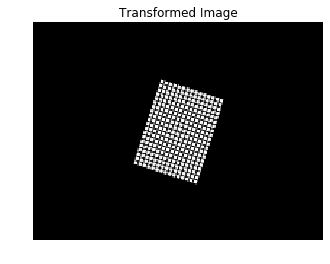

In [20]:
image_tt = transform_image(img,dfield)
imshow_2d(image_tt, 'Transformed Image')

The vector field result as:

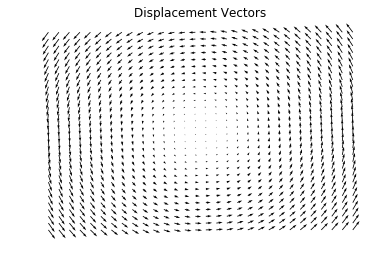

In [21]:
XX, YY, vectorsX, vectorsY = displacement_vectors(img.GetSize(), 
                                                      dfield, samples = 30)
plt.quiver(XX, YY, vectorsX, vectorsY)
plt.title('Displacement Vectors')
plt.axis('off')
plt.show()

Interacting with the spiral function

In [22]:
def imshow_dfield(scale, transform, parameters, image_itk ):
    # Function to bspline transform an image on-line. Intended to be use with interact (Jupyter)
    # Inputs: int, sitk.Transform, bspline_parameters, sitk.Image
    # Output: None
    transform.SetParameters(scale*parameters)
    image_tt = transform_image(image_itk,transform)
    imshow_2d(image_tt, 'Transformed Image')
    
    

interact(imshow_dfield, scale=(-10,10, 0.5), transform = fixed(dfield),
         parameters=fixed(data),image_itk = fixed(img));

interactive(children=(FloatSlider(value=0.0, description='scale', max=10.0, min=-10.0, step=0.5), Output()), _…

## Writing and Reading Transformation Files

SimpleITK allows to store tranformations in files. The transformations can be single or composite transformations. The typical format of a transformation is '.tfm'.

The following example write a composite transformation in a file.

In [ ]:
# Transformations
t1_affine = sitk.AffineTransform(dimension)
t2_dfield = dfield

# Composite transformation
compose1 = sitk.Transform(t2_dfield) # Deformation field transformation
compose1.AddTransform(t1_affine)     # Affine transformation

# Write the transformation in a file
prefix = './output/'
# prefix = '/content/registration_tutorial/' # colabs path
file = 'deformable_transform.tfm'
sitk.WriteTransform(compose1, prefix + file) 

# Read back the file
compose2 = sitk.ReadTransform(prefix + file)
print(compose2)